<div>
<img src="https://raw.githubusercontent.com/euroargodev/virtualfleet/master/docs/img/repo_picture_tight.png" width="500"/>
</div>  

The **objective** of this **demo** is to show you how to use the **VirtualFleet** code in your local python environment with your velocity data. We’ll see how to set up the velocity, how to define your argo deployment plan, how the simulation is performed, and how you can plot the results.

This notebook is for demonstration purposes only and use some sample velocity data (i.e. 9 monthly fields for Gulf Stream area).

***
Notebook prepared by [K Balem](http://github.com/quai20)  

This work is part and was supported by the following projects:
<div>
<img src="https://avatars1.githubusercontent.com/u/58258213?s=460&v=4" width="70" style="float:left"/>
<img src="https://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png" width="200" style="float:left"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="70" style="float:left"/>
</div>

# Requirements
- You should have a working conda/jupyter installation
- Download the code of virtualfleet from github and create a dedicated environment : `conda env create -f environment.yml`. This new kernel should be available in your jupyter-notebook
- If you don't have any velocity data to work with, you can download some sample here : http://collab.umr-lops.fr/app/divaa/virtualfleet/ and copy it into the **data** folder.
***

### Let's start by importing what we need
If you have any issue here, that's probably an installation issue

In [1]:
import sys
import numpy as np
import xarray as xr
import pandas as pd

sys.path.insert(0, "../..") # This is when you load VirtualFleet functions
import virtualargofleet as vaf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature = cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])

# Set-up the velocity field
It's better if your velocity data covers your simulation in time. If your simulation goes outside of your data time coverage, by default, Ocean Parcels will do its best to interpolate the velocities. You also have an option to loop over your velocity field in case you're outside its time coverage. If your simulated argo float goes outside of the regional coverage of your dataset, its advection will stop on the limit of you domain.

In [2]:
# Set up the path of the velocity field
src = "data"

# Set up the dictionnaries to understand the dataset. Here we define in wich file we find the U et V velocities, and the name of the corresponding variables (here 'uo' and 'vo')
filenames = {'U': src + "/2019*.nc",
             'V': src + "/2019*.nc"}
variables = {'U':'uo','V':'vo'}
# The we define the name of the dimension names used in the velocity dataset (here 'time','depth','latitude','longitude')
dimensions = {'time': 'time', 'depth':'depth', 'lat': 'latitude', 'lon': 'longitude'}

Now we can create our **velocity field** instance using `virtualargofleet.velocityfiled()`  

In [5]:
# USAGE : obj = vaf.velocityfield(ds=filenames, var=variables, dim=dimensions, isglobal=0 or 1)
VELfield = vaf.velocityfield(ds=filenames, var=variables, dim=dimensions, isglobal=0)

And we can check it with its `plot()` method. This method plots the first field of the velocity object

/opt/anaconda3/envs/virtualfleet/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/virtualfleet/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
INFO: Unable to locate chunking hints from dask, thus estimating the max. chunk size heuristically. Please consider defining the 'chunk-size' for 'array' in your local dask configuration file (see http://oceanparcels.org/faq.html#field_chunking_config and https://docs.dask.org).
/opt/anaconda3/envs/virtualfleet/lib/python3.6/site-packages/parcels/plotting.py:224: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. I

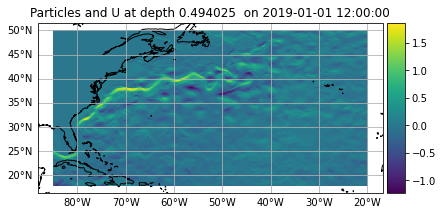

In [4]:
VELfield.plot()

# Now let's define a deployment plan of virtual Argo floats

We're going to define 3 different plans.  
To create a fleet instance, we use the `virtualargofleet.virtualfleet()` method :  
`VFleet = virtualargofleet.virtualfleet(lat=lat, lon=lon, depth=depth, time=time, vfield=vfield, mission=mission)`   
Just be carefull when defining arrays (lat, lon, depth, time), to avoid any issues with compilation, stick to numpy arrays


## Plan A: Random in a small rectangular region

In [8]:
# Number of float we want to simulate
nfloats = 10

# Then we must define numpy array (size nfloats) for lat, lon, depth and time
lon0, lat0 = -70.00, 37.50  # Center of the box
Lx, Ly = 1., 1. # Size of the box
lon = np.random.uniform(lon0-Lx/2, lon0+Lx/2, size=nfloats)
lat = np.random.uniform(lat0-Ly/2, lat0+Ly/2, size=nfloats)
dpt = np.linspace(1.0, 1.0, nfloats) #1m depth
tim = np.array(['2019-01-01' for i in range(nfloats)],dtype='datetime64')

# Mission parameters
parking_depth = 1000. #in m
profile_depth = 2000.
vertical_speed = 0.09 #in m/s
cycle_duration = 10. # in days

mission = {'parking_depth':parking_depth, 'profile_depth':profile_depth, 'vertical_speed':vertical_speed, 'cycle_duration':cycle_duration}

# DEFINE THE FLOAT OBJECT
VFleet = vaf.virtualfleet(lat=lat, lon=lon, depth=dpt, time=tim, vfield=VELfield, mission=mission)

## Plan B: Along a cruise line

In [21]:
# Number of floats we want to simulate:
nfloats = 10

# Define space/time locations of deployments:
lat = np.linspace(30, 38, nfloats)
lon = np.full_like(lat, -60)
dpt = np.linspace(1.0, 1.0, nfloats) #1m depth
#tim = np.array(['2019-01-01' for i in range(nfloats)],dtype='datetime64')
tim = np.arange('2019-01-01','2019-01-11',dtype='datetime64')

# Mission parameters
parking_depth = 750. #in m
profile_depth = 1500.
vertical_speed = 0.09 #in m/s
cycle_duration = 8. # in days

mission = {'parking_depth':parking_depth, 'profile_depth':profile_depth, 'vertical_speed':vertical_speed, 'cycle_duration':cycle_duration}

# DEFINE THE FLOAT OBJECT
VFleet = vaf.virtualfleet(lat=lat, lon=lon, depth=dpt, time=tim, vfield=VELfield, mission=mission)

## Plan C: ASFARish mode, Single location, release through time

In [40]:
nfloats = 4
tim = np.array(['2019-01-01','2019-01-15','2019-02-01','2019-02-15'],dtype='datetime64')
lon = np.array([-40. for i in range(nfloats)])
lat = np.array([35. for i in range(nfloats)])
dpt = np.array([1. for i in range(nfloats)])

# Mission parameters
parking_depth = 1000. #in m
profile_depth = 2000.
vertical_speed = 0.09 #in m/s
cycle_duration = 10. # in days

mission = {'parking_depth':parking_depth, 'profile_depth':profile_depth, 'vertical_speed':vertical_speed, 'cycle_duration':cycle_duration}
VFleet = vaf.virtualfleet(lat=lat, lon=lon, depth=dpt, time=tim, vfield=VELfield, mission=mission)

## Show deployment plan

We can take a look at the internal structure of our fleet

In [45]:
VFleet.pset

P[26](lon=-40.512104, lat=34.662727, depth=1154.000000, cycle_phase=1.000000, cycle_age=763200.000000, drift_age=748800.000000, time=17236800.000000)
P[27](lon=-38.798988, lat=31.878693, depth=1154.000000, cycle_phase=1.000000, cycle_age=423000.000000, drift_age=408600.000000, time=17236800.000000)
P[28](lon=-39.995018, lat=37.288372, depth=1154.000000, cycle_phase=1.000000, cycle_age=693000.000000, drift_age=678600.000000, time=17236800.000000)
P[29](lon=-40.558887, lat=36.973133, depth=1154.000000, cycle_phase=1.000000, cycle_age=352800.000000, drift_age=338400.000000, time=17236800.000000)

We can plot it with the `virtualfleet.plot()`

/opt/anaconda3/envs/virtualfleet/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/virtualfleet/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


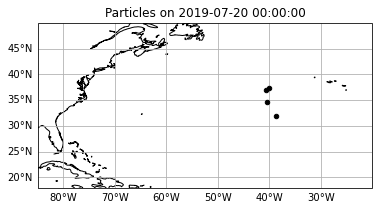

In [46]:
VFleet.plotfloat()

and also check the timing of deployment :

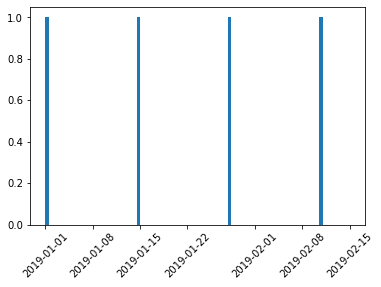

In [47]:
plt.hist(VFleet.time,width=0.5);
plt.xticks(rotation = 45);

# We're ready to run our virtual fleet simulation

In [44]:
%%time
# Define where to store results
output_file = 'out/simulation_03.nc'

# USAGE : float_object.simulate(duration=days,dt_run=hours,dt_out=hours,output_file='my_advection_nXX.nc')
VFleet.simulate(duration=200, dt_run=1/2, dt_out=1, output_file=output_file)

Simulation will be saved in : out/simulation_03.nc


INFO: Compiled ArgoParticleArgoVerticalMovementAdvectionRK4 ==> /tmp/parcels-500721/07b2daff4272f8a0060150f2378252fd_0.so
INFO: Temporary output files are stored in out/out-VPBAYZNH.
INFO: You can use "parcels_convert_npydir_to_netcdf out/out-VPBAYZNH" to convert these to a NetCDF file during the run.
100% |########################################################################|


CPU times: user 56 s, sys: 1.65 s, total: 57.6 s
Wall time: 57.6 s


# Plot the virtual fleet simulation results

In [48]:
# Load simulation results:
simu = xr.open_dataset(output_file)
simu

<xarray.Dataset>
Dimensions:      (obs: 4801, traj: 4)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory   (traj, obs) float64 ...
    time         (traj, obs) datetime64[ns] ...
    lat          (traj, obs) float32 ...
    lon          (traj, obs) float32 ...
    z            (traj, obs) float32 ...
    cycle_phase  (traj, obs) float32 ...
    cycle_age    (traj, obs) float32 ...
    drift_age    (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.1.4
    parcels_mesh:           spherical

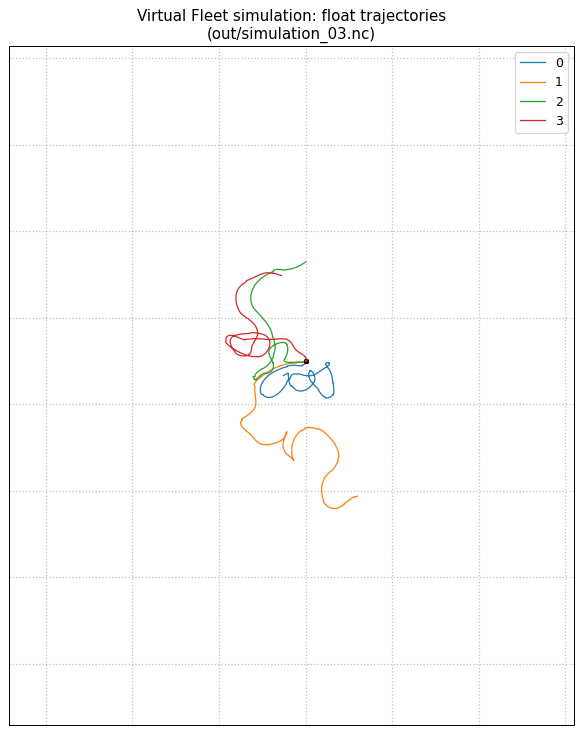

In [49]:
pr1 = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,10), dpi=90)
ax3 = fig.add_subplot(1,1,1,projection=pr1)
ax3.add_feature(land_feature, edgecolor='black')
ax3.set_extent([simu.lon.min()-5, simu.lon.max()+5, simu.lat.min()-5, simu.lat.max()+5])
ax3.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle=':')

for i in simu['traj']:
    this = simu.isel(traj=i).sortby('time')
    ax3.plot(this['lon'][0], this['lat'][0],'k.', transform=pr1)
    ax3.plot(this['lon'], this['lat'],linewidth=1, transform=pr1, label=str(i.values))
    
plt.title("Virtual Fleet simulation: float trajectories\n(%s)" % output_file);
plt.legend()

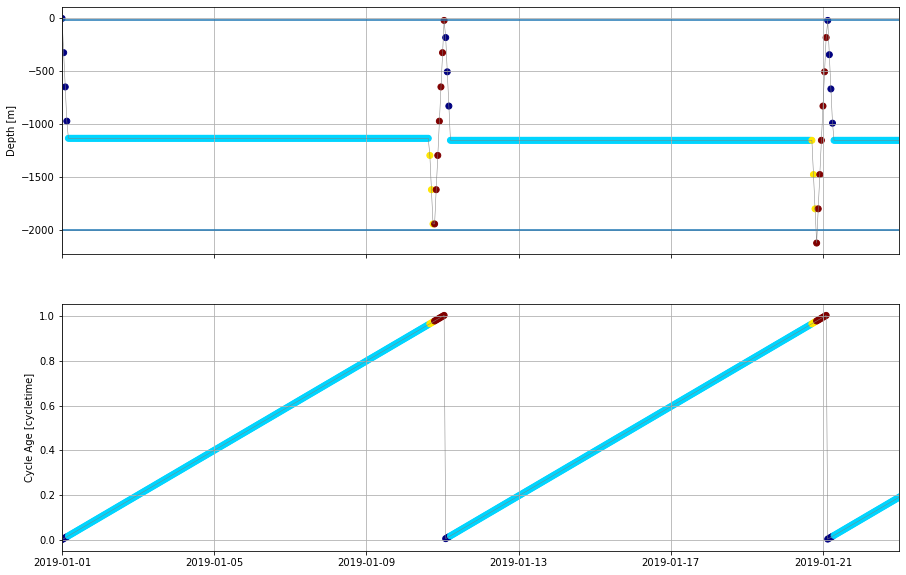

In [50]:
cycletime = 10 * 86400  # in s

trj = simu.isel(traj=0)
# trj = simu.isel(traj=nfloats-1)

dpt = trj['z']
x = trj['time'].values
y = trj['cycle_age']/cycletime

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,10), sharex=True)
ax = ax.flatten()

ax[0].plot(x, -dpt, 'gray', linewidth=0.5)
sc = ax[0].scatter(x, -dpt, c=trj['cycle_phase'], marker='o', cmap=mpl.cm.get_cmap('jet', 4))
ax[0].grid()
ax[0].set_ylabel('Depth [m]')
ax[0].hlines(-20,x[~np.isnan(x)][0], x[~np.isnan(x)][-1])
ax[0].hlines(-2000,x[~np.isnan(x)][0], x[~np.isnan(x)][-1])

ax[1].plot(x, y, 'gray', linewidth=0.5)
sc = ax[1].scatter(x, y, c=trj['cycle_phase'], marker='o', cmap=mpl.cm.get_cmap('jet', 4))
ax[1].set_ylabel('Cycle Age [cycletime]')
ax[1].grid()

[i.set_xlim(x[0], x[int((cycletime/86400+1)*24*2/VFleet.run_params['dt_out'])]) for i in ax];